In [14]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

In [15]:
# Load/Preprocess Data
votes_raw = np.loadtxt('./house-votes-84.data', dtype=object, delimiter=',')
votes_raw[(votes_raw == 'republican') | (votes_raw == 'n')] = -1.
votes_raw[(votes_raw == 'democrat') | (votes_raw == 'y')] = 1.
votes_raw[votes_raw == '?'] = 0
votes = votes_raw
X, y = votes[:, 1:], votes[:, 0]
print(X.shape, y.shape)
np.savetxt('./test_export.txt', votes)

(435, 16) (435,)


# Task 1 - Spectral Clustering

In [16]:
# Function to calculate unnormalized laplacian matrix
def generateUnnormalizedLaplacian(x, sigma):
    W = np.exp(-(x**2)/(2 * sigma**2)).astype(float)
    d = np.sum(W, axis=1) # Sum rows
    D = np.diag(d) # Diagonal matrix of row sums
    L = D - W # Graph laplacian
    lam, Q = np.linalg.eigh(L) # Eigenvalues and vectors
    sort_idx = lam.argsort() # Sort index
    lam_sort = lam[sort_idx] 
    Q_sort = Q[:, sort_idx] # Apply sort
    return lam_sort, Q_sort

In [17]:
# Calculate prediction accuracy of fiedler vector
def calculateAccuracy(Q, y):
    pred = np.sign(Q[:, 1])
    correct = np.count_nonzero(pred == y)
    accuracy = 1 - correct / 435
    accuracy = max(accuracy, 1 - accuracy) # Account for potential negative sign off
    return accuracy

In [18]:
# Generate spatial distance matrix
X_spatial = scipy.spatial.distance_matrix(X, X, p=2)

In [19]:
# Run for specified range
sigmas = np.arange(0.1, 4, step=0.01)
accuracies = [] # List of accuracies
for s in sigmas: # iterate through all sigma
    lam, Q = generateUnnormalizedLaplacian(X_spatial, s) # Generate Laplacian
    s_acc = calculateAccuracy(Q, y) # Calculate accuracy
    accuracies.append(s_acc)

In [20]:
# Best Results
all_best_idxs = np.argwhere(accuracies == np.max(accuracies)).flatten()
all_best_sigmas = sigmas[all_best_idxs]
best_accuracy_idx = np.argmax(accuracies)
best_accuracy = accuracies[best_accuracy_idx]
best_sigma = sigmas[best_accuracy_idx]
print('Best Sigma:', best_sigma, ', Best Accuracy:', best_accuracy)

Best Sigma: 1.1599999999999995 , Best Accuracy: 0.8804597701149426


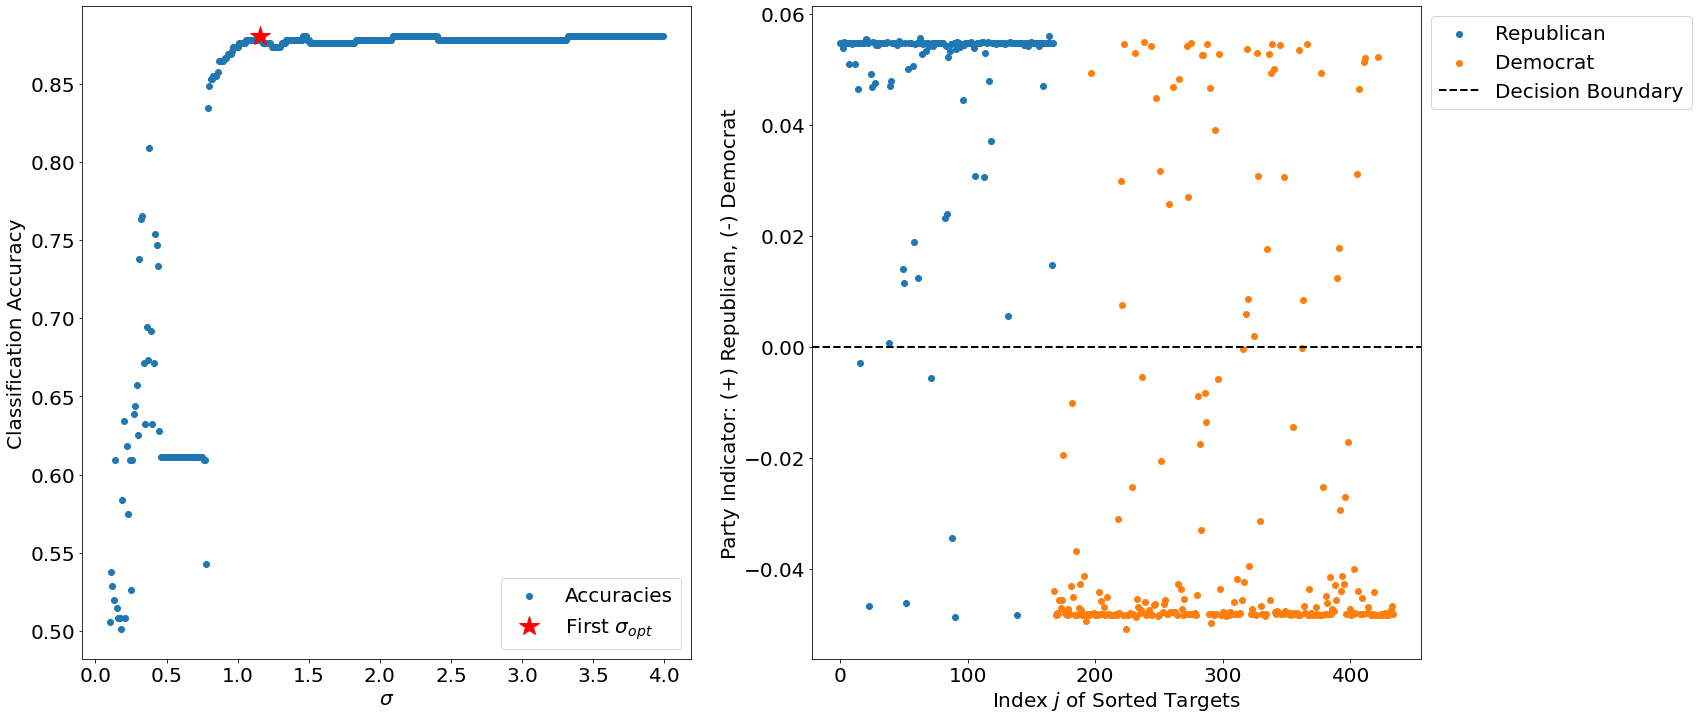

In [21]:
# Plot results
# Get Q_opt
_, Q_opt = generateUnnormalizedLaplacian(X_spatial, best_sigma) # Get the data

# Sort data
y_idx = y.argsort()
y_sort = y[y_idx]
rep_idx = np.where(y_sort == -1) # Republican Index
dem_idx = np.where(y_sort == 1) # Democrat Index
Q_sort = Q_opt[y_idx, :].copy() # Sort values
fied_vec = Q_sort[:, 1] # Get fiedler vector
repub_plot = fied_vec[rep_idx] # Republican indices
dem_plot = fied_vec[dem_idx] # Democrat indices

# Plot Data
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].scatter(sigmas, accuracies, label='Accuracies')
ax[0].plot(best_sigma, best_accuracy, 'r*', markersize=20, label='First $\sigma_{opt}$')
ax[0].set_xlabel('$\sigma$', fontsize=20)
ax[0].set_ylabel('Classification Accuracy', fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].legend(fontsize=20)
ax[1].scatter(rep_idx, repub_plot, label='Republican')
ax[1].scatter(dem_idx, dem_plot, label='Democrat')
ax[1].set_xlabel('Index $j$ of Sorted Targets', fontsize=20)
ax[1].set_ylabel('Party Indicator: (+) Republican, (-) Democrat', fontsize=20)
ax[1].axhline(y=0, linestyle='--', color='black', 
            label='Decision Boundary', linewidth=2)
ax[1].tick_params(labelsize=20)
ax[1].legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.savefig('./Classification_Accuracy.pdf', bbox_inches='tight')
plt.show()

# Task 2 - Semi-Supervised Learning

In [22]:
# Run models using Q_opt
J_vals = [5, 10, 20, 40] # J values to consider (rows)
M_vals = [2, 3, 4, 5, 6] # M values to consider (columns)
best_results = np.ones((len(J_vals), len(M_vals))) # Results vector
model = LinearRegression(fit_intercept=False) # base model
s_best = None
best_preds = None
best_accuracy = 1

for s_opt in all_best_sigmas:
    _, Q_opt = generateUnnormalizedLaplacian(X_spatial, s_opt)
    results = best_results.copy()
    for j_i, j in enumerate(J_vals): # Iterate through all J_vals
        for m_i, m in enumerate(M_vals): # iterate through all m_vals
            A = Q_opt[0:j, 0:m] # Make A matrix
            b = y[0:j] # Make b vector
            model.fit(A, b) # Fit model
            betas = model.coef_ # Get coefficients
            pred = np.dot(Q_opt[:, 0:m] , betas) # Predictions
            correct = np.count_nonzero(np.sign(pred) == y) # how many are correct
            accuracy = 1 - correct / 435 # Convert to accuracy
            results[j_i, m_i] = accuracy # Append results
            if accuracy < best_accuracy:
                best_accuracy = accuracy
                best_preds = pred
    
    if np.min(results) < np.min(best_results):
        s_best = s_opt
        best_results = results
        
print(s_best, 1 - best_accuracy)
print(1 - best_results)

2.249999999999999 0.9287356321839081
[[0.87356322 0.89655172 0.4        0.41149425 0.85977011]
 [0.87126437 0.85977011 0.91724138 0.92873563 0.8045977 ]
 [0.88045977 0.88045977 0.90114943 0.86206897 0.88965517]
 [0.87586207 0.87586207 0.89655172 0.87126437 0.86896552]]


In [23]:
# Save out matrix
np.savetxt('./accuracy_results.csv', best_results, delimiter=',')